# Network Visualization (PyTorch)

1. **Saliency Maps**: Saliency maps are a quick way to tell which part of the image influenced the classification decision made by the network.


In [26]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

### Helper Functions

Our pretrained model was trained on images that had been preprocessed by subtracting the per-color mean and dividing by the per-color standard deviation. We define a few helper functions for performing and undoing this preprocessing. You don't need to do anything in this cell.

# Pretrained Model

For all of our image generation experiments, we will start with a convolutional neural network which was pretrained to perform image classification on ImageNet. We can use any model here, but for the purposes of this assignment we will use SqueezeNet [1], which achieves accuracies comparable to AlexNet but with a significantly reduced parameter count and computational complexity.

Using SqueezeNet rather than AlexNet or VGG or ResNet means that we can easily perform all image generation experiments on CPU.

[1] Iandola et al, "SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and < 0.5MB model size", arXiv 2016

In [27]:
import os
os.chdir('/home/bcasares/cs231n_project/')

In [28]:
# # Download and load the pretrained SqueezeNet model.
# model = torchvision.models.squeezenet1_1(pretrained=True)

# # We don't want to train the model, so tell PyTorch not to compute gradients
# # with respect to model parameters.
# for param in model.parameters():
#     param.requires_grad = False
    
# you may see warning regarding initialization deprecated, that's fine, please continue to next steps

## Load some ImageNet images
We have provided a few example images from the validation set of the ImageNet ILSVRC 2012 Classification dataset. To download these images, descend into `cs231n/datasets/` and run `get_imagenet_val.sh`.

Since they come from the validation set, our pretrained model did not see these images during training.

Run the following cell to visualize some of these images, along with their ground-truth labels.

In [29]:
import utils

In [30]:
from get_model import getModel

In [31]:
model_dir = 'experiments/classes/'
data_dir = ['data/HOUSES_SPLIT','data/HOUSES_SATELLITE_SPLIT']
restore_file = "last"

In [32]:
model, loader_train = getModel(model_dir, data_dir)

In [33]:
# We don't want to train the model, so tell PyTorch not to compute gradients
# with respect to model parameters.
for param in model.parameters():
    param.requires_grad = False

In [34]:
# from model.data_loader2 import fetch_dataloader

# json_path = os.path.join("experiments/base_model", 'params.json')
# params = utils.Params(json_path)
# params.cuda = torch.cuda.is_available()
# loader_train = fetch_dataloader("train", ["data/HOUSES_SPLIT", "data/HOUSES_SATELLITE_SPLIT"], params)["train"]


In [35]:
dir_ = "data/HOUSES_SPLIT/train/20182004001005.jpg"

In [36]:
image = Image.open("data/HOUSES_SPLIT/train/20182004001005.jpg")  # PIL image
image2 = Image.open("data/HOUSES_SATELLITE_SPLIT/train/20182004001005.jpg")  # PIL image

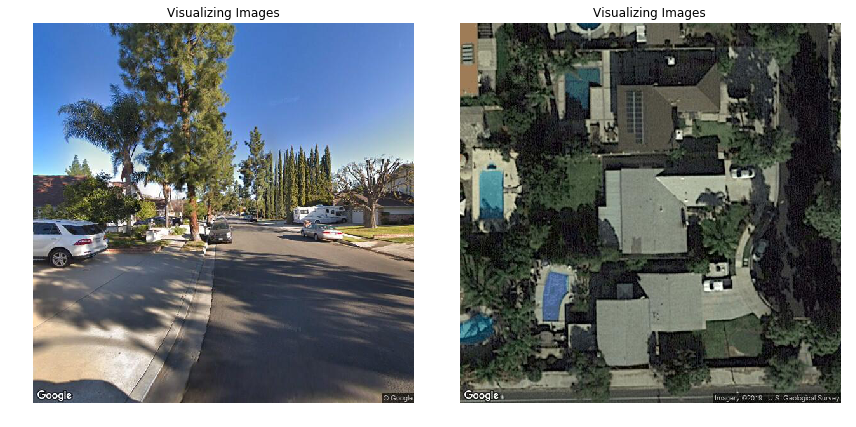

In [37]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Visualizing Images")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(image2)
plt.title("Visualizing Images")
plt.axis('off')
plt.gcf().tight_layout()

In [47]:
device = torch.device('cuda')
for t, (X, y) in enumerate(loader_train):
#     X = X[0]
#     X = X.data.cpu().numpy()
#     y = y.data.cpu().numpy()
    X_see = X
    y_see = y
    X = X.to(device=device, dtype=torch.float)
    y =y.to(device=device, dtype=torch.long)
    break

In [45]:
# y = np.zeros(y.shape)
# y = y.long()

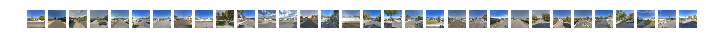

In [48]:
N = X.shape[0]
for i in range(N):
    Xi = X_see[i].detach().numpy()
    Xi = np.transpose(Xi, (1, 2, 0))
    plt.subplot(2, N, i + 1)
    plt.imshow(Xi)
    plt.axis('off')
    plt.gcf().set_size_inches(12, 5)
plt.show()

# Saliency Maps
Using this pretrained model, we will compute class saliency maps as described in Section 3.1 of [2].

A **saliency map** tells us the degree to which each pixel in the image affects the classification score for that image. To compute it, we compute the gradient of the unnormalized score corresponding to the correct class (which is a scalar) with respect to the pixels of the image. If the image has shape `(3, H, W)` then this gradient will also have shape `(3, H, W)`; for each pixel in the image, this gradient tells us the amount by which the classification score will change if the pixel changes by a small amount. To compute the saliency map, we take the absolute value of this gradient, then take the maximum value over the 3 input channels; the final saliency map thus has shape `(H, W)` and all entries are nonnegative.

[2] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

### Hint: PyTorch `gather` method
Recall in Assignment 1 you needed to select one element from each row of a matrix; if `s` is an numpy array of shape `(N, C)` and `y` is a numpy array of shape `(N,`) containing integers `0 <= y[i] < C`, then `s[np.arange(N), y]` is a numpy array of shape `(N,)` which selects one element from each element in `s` using the indices in `y`.

In PyTorch you can perform the same operation using the `gather()` method. If `s` is a PyTorch Tensor of shape `(N, C)` and `y` is a PyTorch Tensor of shape `(N,)` containing longs in the range `0 <= y[i] < C`, then

`s.gather(1, y.view(-1, 1)).squeeze()`

will be a PyTorch Tensor of shape `(N,)` containing one entry from each row of `s`, selected according to the indices in `y`.

run the following cell to see an example.

You can also read the documentation for [the gather method](http://pytorch.org/docs/torch.html#torch.gather)
and [the squeeze method](http://pytorch.org/docs/torch.html#torch.squeeze).

In [55]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    
    # Make input tensor require gradient
    X.requires_grad_()
    scores = model(X)
    scores = scores.gather(1, y.view(-1, 1)).squeeze()  
    one = torch.ones(scores.size())
    one = one.to(device=device, dtype=torch.float)
    scores.backward(one)
    saliency = torch.max(torch.abs(X.grad), dim=1)[0]
    return saliency

Once you have completed the implementation in the cell above, run the following to visualize some class saliency maps on our example images from the ImageNet validation set:

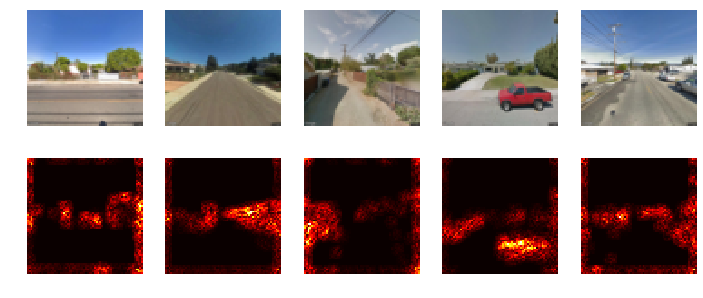

In [61]:
def show_saliency_maps(X, y):
    # Convert X and y from numpy arrays to Torch Tensors
    X_tensor = X
    y_tensor = y
    saliency = compute_saliency_maps(X_tensor, y_tensor, model)
    
    saliency = saliency.data.cpu().numpy()
    X = X.data.cpu().numpy()
    
#     saliency = saliency.numpy()
#     N = X.shape[0]
    N = 5
    for i in range(N):
        Xi = X[i] #.detach().numpy()
        Xi = np.transpose(Xi, (1, 2, 0))
        plt.subplot(2, N, i + 1)
        plt.imshow(Xi)
        plt.axis('off')
#         plt.title(class_names[y[i]])
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()

show_saliency_maps(X, y)